In [1]:
# https://keras.io/
!pip install -q keras
!pip install graphviz
import keras

import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Activation, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from PIL import Image

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 10
num_filter = 20

Using TensorFlow backend.


In [2]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)  

In [13]:
from keras import layers
input_layer = Input(shape=(img_height, img_width, channel,))

# Layer 1, 5x5 Separable , Depthwise
Layer1 = SeparableConv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_layer)
Layer1_normalized = BatchNormalization(name='norm_1')(Layer1)
Layer1_normalized_activated = Activation('relu')(Layer1_normalized)

Layer1_normalized_activated = Dropout(0.2)(Layer1_normalized_activated)

# Layer 2,Normal Conv2d 5x5
Layer2 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_2', use_bias=False)(Layer1_normalized_activated)
Layer2_normalized = BatchNormalization(name='norm_2')(Layer2)
Layer2_normalized_activated = Activation('relu')(Layer2_normalized)

Layer2_normalized_activated = Dropout(0.2)(Layer2_normalized_activated)

# Layer 3, Normal Conv2d 5x5
Layer3 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_3', use_bias=False)(Layer2_normalized_activated)
Layer3_normalized = BatchNormalization(name='norm_3')(Layer3)
Layer3_normalized_activated = Activation('relu')(Layer3_normalized)
Layer3_normalized_activated = Dropout(0.2)(Layer3_normalized_activated)

Layers_1_3_concatenated = concatenate([Layer1_normalized_activated,Layer3_normalized_activated])

# Layer 4, 5x5 Separable
Layer4 = SeparableConv2D(64, (5,5), strides=(1,1), padding='same', name='conv_4', use_bias=False)(Layers_1_3_concatenated)
Layer4_normalized = BatchNormalization(name='norm_4')(Layer4)
Layer4_normalized_activated = Activation('relu')(Layer4_normalized)
Layer4_normalized_activated = Dropout(0.2)(Layer4_normalized_activated)

Layers_1_4_concatenated = concatenate([Layer1_normalized_activated,Layer4_normalized_activated])

#Maxpool layer
Layer_maxpool1 = MaxPooling2D(pool_size=(2, 2))(Layers_1_4_concatenated) #16

#Bottleneck 1x1 to reduce params
Layer_bottleneck1 = Conv2D(32, (1, 1), activation='relu')(Layer_maxpool1)

# Layer 5, 3x3 Separable , Depthwise
Layer5 = SeparableConv2D(64, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(Layer_bottleneck1)
Layer5_normalized = BatchNormalization(name='norm_5')(Layer5)
Layer5_normalized_activated = Activation('relu')(Layer5_normalized)
Layer5_normalized_activated = Dropout(0.2)(Layer5_normalized_activated)

Layers_1_4_5_concatenated = concatenate([Lambda(space_to_depth_x2)(Layer1_normalized_activated),Lambda(space_to_depth_x2)(Layer4_normalized_activated),Layer5_normalized_activated])

# Layer 6, Normal Conv2d 5x5
Layer6 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_6', use_bias=False)(Layers_1_4_5_concatenated)
Layer6_normalized = BatchNormalization(name='norm_6')(Layer6)
Layer6_normalized_activated = Activation('relu')(Layer6_normalized)
Layer6_normalized_activated = Dropout(0.2)(Layer6_normalized_activated)

Layers_3_4_5_6_concatenated = concatenate([Lambda(space_to_depth_x2)(Layer3_normalized_activated),Lambda(space_to_depth_x2)(Layer4_normalized_activated),Layer5_normalized_activated,Layer6_normalized_activated])

# Layer 7, 3x3 Separable , Depthwise
Layer7 = SeparableConv2D(64, (3,3), strides=(1,1), padding='same', name='conv_7', use_bias=False)(Layers_3_4_5_6_concatenated)
Layer7_normalized = BatchNormalization(name='norm_7')(Layer7)
Layer7_normalized_activated = Activation('relu')(Layer7_normalized)
Layer7_normalized_activated = Dropout(0.2)(Layer7_normalized_activated)

Layers_1_3_4_5_6_7_concatenated = concatenate([Lambda(space_to_depth_x2)(Layer1_normalized_activated),Lambda(space_to_depth_x2)(Layer3_normalized_activated),Lambda(space_to_depth_x2)(Layer4_normalized_activated),Layer5_normalized_activated,Layer6_normalized_activated,Layer7_normalized_activated])

# Layer 8, 5x5 Separable Depthwise.
Layer8 = SeparableConv2D(64, (5,5), strides=(1,1), padding='same', name='conv_8', use_bias=False)(Layers_1_3_4_5_6_7_concatenated)
Layer8_normalized = BatchNormalization(name='norm_8')(Layer8)
Layer8_normalized_activated = Activation('relu')(Layer8_normalized)
Layer8_normalized_activated = Dropout(0.2)(Layer8_normalized_activated)

Layers_1_4_7_8_concatenated = concatenate([Lambda(space_to_depth_x2)(Layer1_normalized_activated),Lambda(space_to_depth_x2)(Layer4_normalized_activated),Layer7_normalized_activated,Layer8_normalized_activated])

Layer_maxpool2 = MaxPooling2D(pool_size=(2, 2))(Layers_1_4_7_8_concatenated) #8

Layers_6_maxpool2_concatenated = concatenate([Lambda(space_to_depth_x2)(Layer6_normalized_activated),Layer_maxpool2])

#Bottleneck 1x1 to reduce params
Layer_bottleneck2 = Conv2D(64, (1, 1), activation='relu')(Layers_6_maxpool2_concatenated)

# Layer 9
Layer9 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_9', use_bias=False)(Layer_bottleneck2)
Layer9_normalized = BatchNormalization(name='norm_9')(Layer9)
Layer9_normalized_activated = Activation('relu')(Layer9_normalized)
Layer9_normalized_activated = Dropout(0.2)(Layer9_normalized_activated)

Layers_1_2_7_9_concatenated = concatenate([Lambda(space_to_depth_x4)(Layer1_normalized_activated),Lambda(space_to_depth_x4)(Layer2_normalized_activated),Lambda(space_to_depth_x2)(Layer7_normalized_activated),Layer9_normalized_activated])

# Layer 10,5x5 Separable , Depthwise
Layer10 = SeparableConv2D(64, (5,5), strides=(1,1), padding='same', name='conv_10', use_bias=False)(Layers_1_2_7_9_concatenated)
Layer10_normalized = BatchNormalization(name='norm_10')(Layer10)
Layer10_normalized_activated = Activation('relu')(Layer10_normalized)
Layer10_normalized_activated = Dropout(0.2)(Layer10_normalized_activated)

Layers_2_3_5_9_10_concatenated = concatenate([Lambda(space_to_depth_x4)(Layer2_normalized_activated),Lambda(space_to_depth_x4)(Layer3_normalized_activated),Lambda(space_to_depth_x2)(Layer5_normalized_activated),Layer9_normalized_activated,Layer10_normalized_activated])

# Layer 11, Normal Conv2d 3x3
Layer11 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(Layers_2_3_5_9_10_concatenated)
Layer11_normalized = BatchNormalization(name='norm_11')(Layer11)
Layer11_normalized_activated = Activation('relu')(Layer11_normalized)
Layer11_normalized_activated = Dropout(0.2)(Layer11_normalized_activated)

Layers_3_4_5_7_10_11_concatenated = concatenate([Lambda(space_to_depth_x4)(Layer3_normalized_activated),Lambda(space_to_depth_x4)(Layer4_normalized_activated),Lambda(space_to_depth_x2)(Layer5_normalized_activated),Lambda(space_to_depth_x2)(Layer7_normalized_activated),Layer10_normalized_activated,Layer11_normalized_activated])

# Layer 12 -  5x5 Separable , Depthwise
Layer12 = SeparableConv2D(64, (3,3), strides=(1,1), padding='same', name='conv_12', use_bias=False)(Layers_3_4_5_7_10_11_concatenated)
Layer12_normalized = BatchNormalization(name='norm_12')(Layer12)
Layer12_normalized_activated = Activation('relu')(Layer12_normalized)
Layer12_normalized_activated = Dropout(0.2)(Layer12_normalized_activated)

Layers_4_7_10_12_concatenated = concatenate([Lambda(space_to_depth_x4)(Layer4_normalized_activated), Lambda(space_to_depth_x2)(Layer7_normalized_activated), Layer10_normalized_activated, Layer12_normalized_activated])

Layer_bottleneck3 = Conv2D(10, (1,1), strides=(1,1), padding='same', name='conv_f1', use_bias=False)(Layers_4_7_10_12_concatenated)
#Layer_f2 = Conv2D(10, (8,8), strides=(1,1), name='conv_f2', use_bias=False)(Layer_bottleneck3)

img_output = AveragePooling2D(8,8)(Layer_bottleneck3)
img_output=  Flatten()(img_output)
img_output = Activation('softmax')(img_output)

model = Model(inputs=[input_layer], outputs=[img_output])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (SeparableConv2D)        (None, 32, 32, 32)   171         input_6[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 32, 32, 32)   0           norm_1[0][0]                     
__________________________________________________________________________________________________
dropout_13

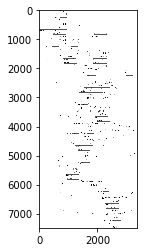

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.core.display import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image( filename ='model_plot.png')

img = mpimg.imread('model_plot.png')
plt.imshow(img)
plt.show()

In [0]:
# determine Loss function and Optimizer
(model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy']))

In [16]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 72s 1ms/step - loss: 1.3520 - acc: 0.5095 - val_loss: 1.2382 - val_acc: 0.5664
Epoch 2/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.9494 - acc: 0.6589 - val_loss: 1.2103 - val_acc: 0.5942
Epoch 3/50
50000/50000 [==============================] - 67s 1ms/step - loss: 0.7690 - acc: 0.7279 - val_loss: 0.8914 - val_acc: 0.6931
Epoch 4/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.6588 - acc: 0.7687 - val_loss: 0.9719 - val_acc: 0.6765
Epoch 5/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.5793 - acc: 0.7981 - val_loss: 1.2326 - val_acc: 0.6218
Epoch 6/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.5132 - acc: 0.8205 - val_loss: 0.7389 - val_acc: 0.7536
Epoch 7/50
50000/50000 [==============================] - 68s 1ms/step - loss: 0.4620 - acc: 0.8407 - val_loss: 1.1173 - val_acc

In [18]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save the trained weights in to .h5 format
model.save_weights("CIFR_densenet_Basic_model2.h5")
print("Saved the model to disk")

10000/10000 [==============================] - 5s 488us/step
Test loss: 0.7610598748207092
Test accuracy: 0.8346
Saved the model to disk


In [0]:
model.save_weights("CIFR_densenet_Basic_model2.h5")
print("Saved the model to disk")
from google.colab import files

files.download('CIFR_densenet_Basic_model2.h5')

In [17]:
# Some more changes can be definitely done to improve accuracy here, will attempt once I get some more time
print("Best validation accuracy is : 0.8387")
print("Best training accuracy is : 0.9839")

Best validation accuracy is : 0.8387
Best training accuracy is : 0.9839
